In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree # 解析xml文件信息
import numpy as np
import glob # 获取图像位置
# 引入绘制矩形框的方法
from matplotlib.patches import Rectangle

In [2]:
img = tf.io.read_file('D:/Desktop/数据集/图片定位与分割数据集/images/images/Abyssinian_1.jpg')

In [3]:
img = tf.image.decode_jpeg(img)

In [4]:
img.shape

TensorShape([400, 600, 3])

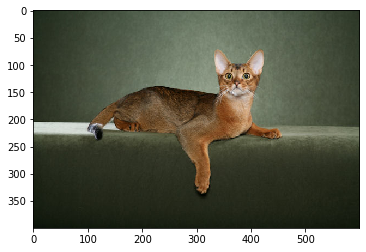

In [5]:
plt.imshow(img)

In [6]:
# 读取xml文件中的内容
xml = open('D:/Desktop/数据集/图片定位与分割数据集/annotations/annotations/xmls/Abyssinian_1.xml').read()

In [7]:
xml

'<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>\n'

In [8]:
# 创建选择器
sel = etree.HTML(xml)

In [9]:
# 解析文件中的图片数据
width = int(sel.xpath('//size/width/text()')[0])
height = int(sel.xpath('//size/height/text()')[0])
xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
ymax = int(sel.xpath('//bndbox/ymax/text()')[0])

In [10]:
ymin

72

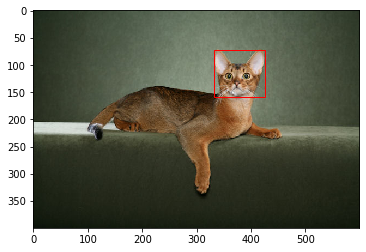

In [11]:
plt.imshow(img)
# 绘制矩形框，((x,y),h,w)    fill指定是否填充矩形框
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
# 获取当前图像
ax = plt.gca()
# 添加矩形框
ax.axes.add_patch(rect)

In [12]:
img = tf.image.resize(img,[224,224])

In [13]:
# 根据图像原来的尺寸确定xmin，xmax，ymin，ymax的比例大小从而确定对应数值在新尺寸图像中的大小
xmin = (xmin/width)*224
xmax = (xmax/width)*224
ymin = (ymin/height)*224
ymax = (ymax/height)*224

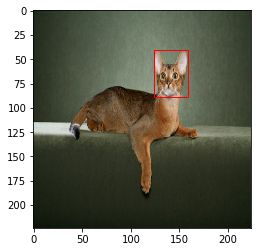

In [14]:
plt.imshow(img/255)
# 绘制矩形框，((x,y),h,w)    fill指定是否填充矩形框
rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
# 获取当前图像
ax = plt.gca()
# 添加矩形框
ax.axes.add_patch(rect)

# 创建输入管道

In [15]:
# 读取所有的图像
images = glob.glob('D:\\Desktop\\数据集\\图片定位与分割数据集\\images\\images\\*.jpg')

In [16]:
images[0]

'D:\\Desktop\\数据集\\图片定位与分割数据集\\images\\images\\Abyssinian_1.jpg'

In [17]:
len(images)

7390

In [18]:
# 获取图片对应的目标值xml文件
xmls = glob.glob('D:\\Desktop\\数据集\\图片定位与分割数据集\\annotations\\annotations\\xmls\\*.xml')  

In [19]:
len(xmls)

3686

In [20]:
# 获取所有解析文件的图片名称
names = [x.split('\\xmls\\')[1].split('.')[0] for x in xmls]

In [21]:
len(names)

3686

In [22]:
# 取出names中存在的所有图片名称对应的路径
imgs_train = [img for img in images if(img.split('\\images\\images\\')[1].split('.')[0]) in names]

In [23]:
len(imgs_train)

3686

In [24]:
# 取出names中不存在的所有图片名称对应的路径
imgs_test = [img for img in images if(img.split('\\images\\images\\')[1].split('.')[0]) not in names]

In [25]:
len(imgs_test)

3704

In [26]:
# 根据名称进行排序
imgs_train.sort(key = lambda x:x.split('\\images\\images\\')[1].split('.')[0])
xmls.sort(key = lambda x:x.split('\\xmls\\')[1].split('.')[0])

In [27]:
def to_labels(path):
    # 读取xml文件
    xml = open('{}'.format(path)).read()
    # 创建一个选择器
    sel = etree.HTML(xml)
    # 解析xml文件中的图片数据
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    # 返回xmin等值与图像尺寸的比例
    return [xmin/width,ymin/height,xmax/width,ymax/height]

In [28]:
# 获取所有路径的标签，标签由xmin、xmax、ymin、ymax组成
labels = [to_labels(path) for path in xmls]

In [29]:
labels[:3]

[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [30]:
# 将获取到的标签分为四个单独的列表
out1,out2,out3,out4 = list(zip(*labels))

In [31]:
out1 = np.array(out1)
out2 = np.array(out2)
out3 = np.array(out3)
out4 = np.array(out4)

In [32]:
label_dataset = tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4))

In [33]:
label_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.float64, tf.float64, tf.float64, tf.float64)>

In [34]:
# 加载图片数据
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,(224,224))
    # 归一化到-1到1之间
    img = img/127.5-1
    return img

In [35]:
# 创建训练图片数据集
image_dataset = tf.data.Dataset.from_tensor_slices(imgs_train)

In [36]:
image_dataset = image_dataset.map(load_image)

In [37]:
image_dataset

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [38]:
# 合并生成训练数据集
dataset = tf.data.Dataset.zip((image_dataset,label_dataset))

In [39]:
dataset

<ZipDataset shapes: ((224, 224, 3), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [40]:
dataset = dataset.repeat().shuffle(len(imgs_train)).batch(32)

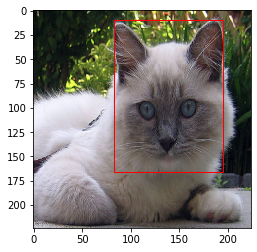

In [41]:
for img,label in dataset.take(1):
    # 将tensor array对象转换为img
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    out1,out2,out3,out4 = label
    # 按照原比例获取xmin,ymin,xamx,ymax
    xmin,ymin,xmax,ymax = out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    # 绘制矩形框，((x,y),h,w)    fill指定是否填充矩形框
    rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
    # 获取当前图像
    ax = plt.gca()
    # 添加矩形框
    ax.axes.add_patch(rect)
    plt.show()

# 创建图像定位模型

In [42]:
# 使用预训练网络
xception = tf.keras.applications.Xception(weights='imagenet',
                                         include_top=False,
                                         input_shape=(224,224,3))

In [43]:
# 将预训练网络设置为不可训练
xception.trainable = False

In [44]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048,activation='relu')(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
# 回归
out1 = tf.keras.layers.Dense(1)(x)
out2 = tf.keras.layers.Dense(1)(x)
out3 = tf.keras.layers.Dense(1)(x)
out4 = tf.keras.layers.Dense(1)(x)
prediction = [out1,out2,out3,out4]
model = tf.keras.models.Model(inputs=inputs,outputs=prediction)

In [45]:
# 编译、配置模型
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='mse', # 回归问题常用损失函数
              metrics=['mae'] # 绝对损失计算
             )

In [46]:
EPOCHS = 50

In [47]:
history = model.fit(dataset,
                   epochs=EPOCHS,
                   steps_per_epoch=(len(imgs_train)//32)
                   )

Epoch 1/50
115/115 [==============================] - 624s 5s/step - loss: 0.1403 - dense_2_loss: 0.0363 - dense_3_loss: 0.0183 - dense_4_loss: 0.0438 - dense_5_loss: 0.0419 - dense_2_mae: 0.1443 - dense_3_mae: 0.1044 - dense_4_mae: 0.1592 - dense_5_mae: 0.1529
Epoch 2/50
115/115 [==============================] - 626s 5s/step - loss: 0.0654 - dense_2_loss: 0.0183 - dense_3_loss: 0.0099 - dense_4_loss: 0.0207 - dense_5_loss: 0.0166 - dense_2_mae: 0.1061 - dense_3_mae: 0.0768 - dense_4_mae: 0.1131 - dense_5_mae: 0.1017
Epoch 3/50
115/115 [==============================] - 666s 6s/step - loss: 0.0481 - dense_2_loss: 0.0134 - dense_3_loss: 0.0076 - dense_4_loss: 0.0155 - dense_5_loss: 0.0116 - dense_2_mae: 0.0906 - dense_3_mae: 0.0674 - dense_4_mae: 0.0976 - dense_5_mae: 0.0842
Epoch 4/50
115/115 [==============================] - 630s 5s/step - loss: 0.0343 - dense_2_loss: 0.0103 - dense_3_loss: 0.0055 - dense_4_loss: 0.0106 - dense_5_loss: 0.0079 - dense_2_mae: 0.0788 - dense_3_mae: 0.0

Epoch 32/50
115/115 [==============================] - 595s 5s/step - loss: 0.0060 - dense_2_loss: 0.0015 - dense_3_loss: 9.6824e-04 - dense_4_loss: 0.0019 - dense_5_loss: 0.0016 - dense_2_mae: 0.0306 - dense_3_mae: 0.0243 - dense_4_mae: 0.0336 - dense_5_mae: 0.0312
Epoch 33/50
115/115 [==============================] - 587s 5s/step - loss: 0.0053 - dense_2_loss: 0.0014 - dense_3_loss: 8.0879e-04 - dense_4_loss: 0.0018 - dense_5_loss: 0.0013 - dense_2_mae: 0.0293 - dense_3_mae: 0.0223 - dense_4_mae: 0.0335 - dense_5_mae: 0.0276
Epoch 34/50
115/115 [==============================] - 598s 5s/step - loss: 0.0057 - dense_2_loss: 0.0016 - dense_3_loss: 8.7473e-04 - dense_4_loss: 0.0019 - dense_5_loss: 0.0013 - dense_2_mae: 0.0315 - dense_3_mae: 0.0233 - dense_4_mae: 0.0340 - dense_5_mae: 0.0287
Epoch 35/50
115/115 [==============================] - 607s 5s/step - loss: 0.0052 - dense_2_loss: 0.0015 - dense_3_loss: 8.7108e-04 - dense_4_loss: 0.0017 - dense_5_loss: 0.0012 - dense_2_mae: 0.029

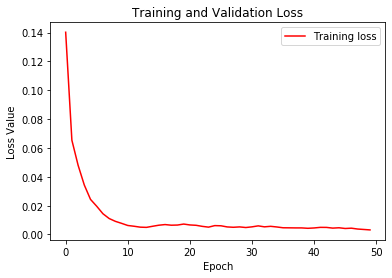

In [52]:
loss = history.history['loss']
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs,loss,'r',label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# 规定取值范围
#plt.ylim([0,1])
plt.legend()
plt.show()

# 模型保存

In [54]:
model.save('detect_v1.h5')

In [55]:
new_model = tf.keras.models.load_model('detect_v1.h5')

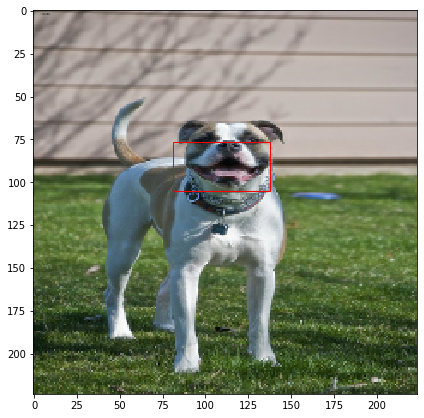

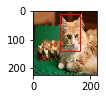

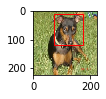

In [57]:
# 创建一张画布
plt.figure(figsize=(8,24))
for img, _ in dataset.take(1):
    out1,out2,out3,out4 = new_model.predict(img)
    for i in range(3):
        # 绘制子图，3行1列的第一个子图。====subplot是从1开始编号的====
        plt.subplot(3,1,i+1) 
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin,ymin,xmax,ymax = out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        # 绘制矩形框，((x,y),h,w)    fill指定是否填充矩形框
        rect = Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
        # 获取当前图像
        ax = plt.gca()
        # 添加矩形框
        ax.axes.add_patch(rect)
        plt.show()